In [149]:
!python -m pip install --index-url https://support.bayesfusion.com/pysmile-A/ pysmile

Looking in indexes: https://support.bayesfusion.com/pysmile-A/, https://us-python.pkg.dev/colab-wheels/public/simple/


In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.special import expit
import itertools
import pysmile

In [ ]:
pysmile.License((
	b"SMILE LICENSE 809da930 df31fca2 70cfb3dc "
	b"THIS IS AN ACADEMIC LICENSE AND CAN BE USED "
	b"SOLELY FOR ACADEMIC RESEARCH AND TEACHING, "
	b"AS DEFINED IN THE BAYESFUSION ACADEMIC "
	b"SOFTWARE LICENSING AGREEMENT. "
	b"Serial #: 9wycnvvmtgqhchs8tpfu71dkq "
	b"Issued for: Jaime Perez (jaime.perez.sanchez@gmail.com) "
	b"Academic institution: Universidad Pontificia Comillas "
	b"Valid until: 2023-03-16 "
	b"Issued by BayesFusion activation server"
	),[
	0xcb,0x90,0x44,0xb9,0x6c,0x57,0xfa,0x97,0xd5,0x13,0xc4,0x9f,0x19,0x83,0x8c,0xa8,
	0x49,0xf3,0x74,0xef,0xa2,0x6a,0xf0,0xf3,0x8c,0xf7,0x43,0x51,0x9c,0x1d,0x43,0x57,
	0xc2,0x74,0xe0,0x97,0xb6,0x0b,0x4c,0xde,0x05,0xc7,0x5e,0xf7,0x13,0x48,0xe3,0x55,
	0xea,0xce,0x72,0x85,0xb9,0x01,0x39,0x86,0x66,0x34,0xf9,0xc4,0xaa,0xe3,0xb4,0x75])

## Simulator

In [165]:
### Inputs 

n_players = 500

# mean and var of the profile distributions
profiles_risk = {'safe': [-2, 0.6],
                 'risky': [0.5, 1.2]}

# Prevalences of Demographics
prevalence_gender_lst = [0.5, 0.5]  # Female / Male
gender_dict = {'Female': -1,
               'Male' : 1}
prevalence_age_lst = [0.2, 0.2, 0.2, 0.2, 0.2]  # 13 / 14 / 15 / 16 / 17
age_dict = {'Age_13': -1,
            'Age_14' : -0.5,
            'Age_15' : 0,
            'Age_16' : 0.5,
            'Age_17' : 1}  
prevalence_sex_orient_lst = [0.85, 0.15]  # Heterosexual / Non Heterosexual
sex_orient_dict = {'Heterosexual': -1,
                   'Non_Heterosexual' : 1}  
prevalence_immigrant_lst = [0.75, 0.25]  # Heterosexual / Non Heterosexual
immigrant_dict = {'Non_Immigrant': -1,
                  'Immigrant' : 1}                    
                          
# Questions in the game
n_questions = 15
questions_output = {'safe_answer' : 0,
                    'risky_answer': 1}
low_limit_question = 0
high_limit_question = 1


### Create Demographics

def generate_demograpics(prevalence_gender, prevalence_age, prevalence_sex_orient, prevalence_immigrant):
  gender = np.random.choice(list(gender_dict.keys()), p=prevalence_gender)
  age = np.random.choice(list(age_dict.keys()), p=prevalence_age)
  sex_orient = np.random.choice(list(sex_orient_dict.keys()), p=prevalence_sex_orient)
  immigrant = np.random.choice(list(immigrant_dict.keys()), p=prevalence_immigrant)

  return gender, age, sex_orient, immigrant

### Causal model
def causal_model(gender, age, sex_orient, immigrant):
  net = pysmile.Network()
  net.read_file("Network7.xdsl")
  net.set_evidence("Gender", gender)
  net.set_evidence("Age", age)
  net.set_evidence("SO", sex_orient)
  net.set_evidence("Immigrant_son", immigrant)
  net.update_beliefs()

  beliefs = net.get_node_value("CB")
  prob_CB = beliefs[1]
  prob_non_CB = 1 - prob_CB

  # Toss a coin
  profile_label = np.random.choice(list(profiles_risk.keys()), p=[prob_non_CB, prob_CB])
  risk_params = profiles_risk[profile_label]
  alpha_risk = np.random.normal(risk_params[0], risk_params[1])

  return alpha_risk, profile_label

### Players

class Player:
  def __init__(self, prevalence_gender, prevalence_age, prevalence_sex_orient, prevalence_immigrant):
    self.gender, self.age, self.sex_orient, self.immigrant = generate_demograpics(prevalence_gender, prevalence_age, prevalence_sex_orient, prevalence_immigrant)
    self.alpha_risk, self.risk_profile = causal_model(self.gender, self.age, self.sex_orient, self.immigrant)
  
  def play_game(self, game, mode='2PL_modified'):
    answers_player = []
    for question in game.difficulty_questions:
      if mode == 'weights':
        # Prob. to answer risky = p(i) * (1-W(j)) + 0.5 * W(j)
        prob_answer_risky = self.alpha_risk * (1-question) + 0.5 * question
      elif mode == 'rasch':
        # Prob. to answer risky = 1 / 1+e^(Q-P)
        prob_answer_risky = 1/(1 + math.exp(question - self.alpha_risk))
      elif mode == '2PL_modified':
        # Prob. to answer risky = 1 / 1+e^(-P*Q)
        prob_answer_risky = 1/(1 + math.exp(-(self.alpha_risk) * question))
      prob_answer_safe = 1 - prob_answer_risky
      answer = np.random.choice(list(questions_output.values()), p=[prob_answer_safe, prob_answer_risky])
      answers_player.append(answer)
    # Add risk
    answers_player.append(self.alpha_risk)
    answers_player.append(self.risk_profile)
    # Add demographics
    answers_player.append(self.gender)
    answers_player.append(self.age)
    answers_player.append(self.sex_orient)
    answers_player.append(self.immigrant)

    return answers_player


### Game

class Game:
  def __init__(self, n=10, low=0, high=1):
    self.low_limit = low
    self.high_limit = high
    self.difficulty_questions = np.random.uniform(low=self.low_limit, high=self.high_limit, size=n)
  
  def get_len_game(self):
    return len(self.difficulty_questions)

In [166]:
# Columns names

columns_names = []
dict_types = {}
for j in range(n_questions):
  name = f'Q_{j+1}'
  dict_types[name] = int
  columns_names.append(name)
columns_names.append('alpha_risk')
columns_names.append('risk_label')
columns_names.append('gender')
columns_names.append('age')
columns_names.append('sex_orient')
columns_names.append('immigrant')

## Let's Play!!

In [167]:
# Create game
game_1 = Game(n=n_questions, low=low_limit_question, high=high_limit_question)

lst_players = [Player(prevalence_gender_lst, prevalence_age_lst, prevalence_sex_orient_lst, prevalence_immigrant_lst) for _ in range(n_players)]

In [168]:
# Create Dataframe
Dataset = pd.DataFrame(columns=columns_names)

# Play!
for participant in lst_players:
  answers = participant.play_game(game_1, mode='2PL_modified')
  Dataset.loc[Dataset.shape[0]] = answers

Dataset.to_csv('Data_V3.csv')
pd.set_option('display.max_columns', 30)
Dataset

,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,Q_9,Q_10,Q_11,Q_12,Q_13,Q_14,Q_15,alpha_risk,risk_label,gender,age,sex_orient,immigrant
0,1,1,1,0,0,0,1,1,0,0,1,0,1,1,0,0.941594,risky,Male,Age_14,Heterosexual,Non_Immigrant
1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,-2.648099,safe,Female,Age_17,Heterosexual,Non_Immigrant
2,0,0,0,0,1,0,1,1,1,1,0,0,0,0,0,-2.022577,safe,Male,Age_16,Heterosexual,Non_Immigrant
3,0,0,1,1,1,1,0,1,0,1,0,1,0,1,0,-0.055450,risky,Male,Age_17,Heterosexual,Non_Immigrant
4,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,-1.263072,safe,Female,Age_13,Heterosexual,Immigrant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1,0,0,0,0,0,1,1,0,0,1,1,1,1,1,1.187809,risky,Female,Age_14,Non_Heterosexual,Non_Immigrant
496,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,-1.341331,safe,Female,Age_14,Heterosexual,Non_Immigrant
497,0,0,1,1,0,1,1,0,0,0,1,1,1,0,0,-1.494339,safe,Female,Age_15,Heterosexual,Non_Immigrant
498,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,-2.045617,safe,Male,Age_13,Heterosexual,Non_Immigrant


In [169]:
Dataset['risk_label'].value_counts()

safe     304
risky    196
Name: risk_label, dtype: int64

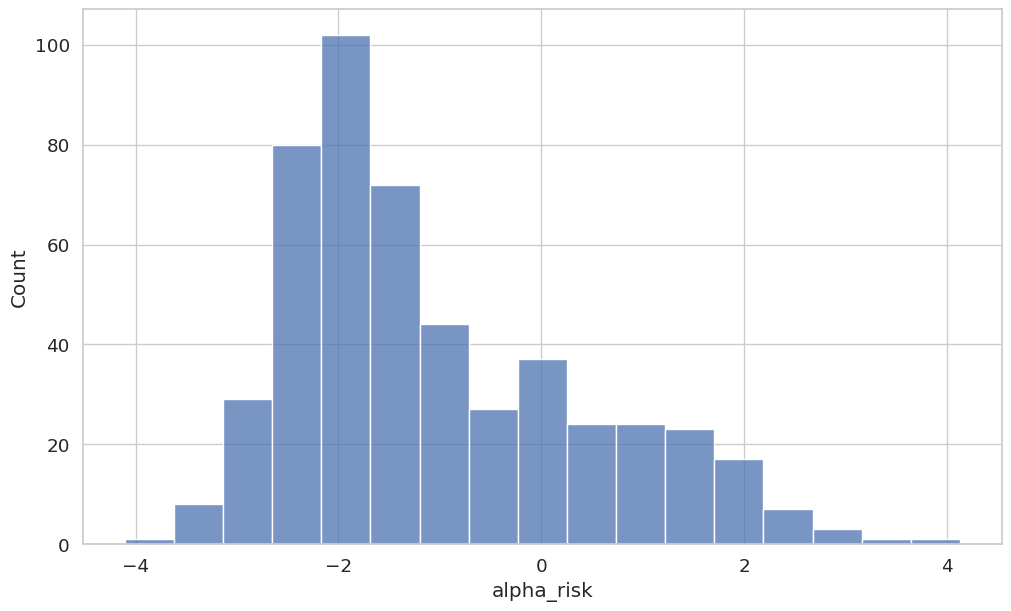

In [170]:
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))

sns.histplot(Dataset['alpha_risk'], bins='auto')

plt.ylabel('Count')
plt.show()

### Analyze the data

In [171]:
data_1 = Dataset[Dataset.columns[:n_questions]]
questions = [sum(data_1.iloc[:, i]==1) for i in range(data_1.shape[1])]
print(questions)

[157, 185, 210, 238, 240, 196, 221, 162, 195, 238, 196, 203, 221, 175, 208]


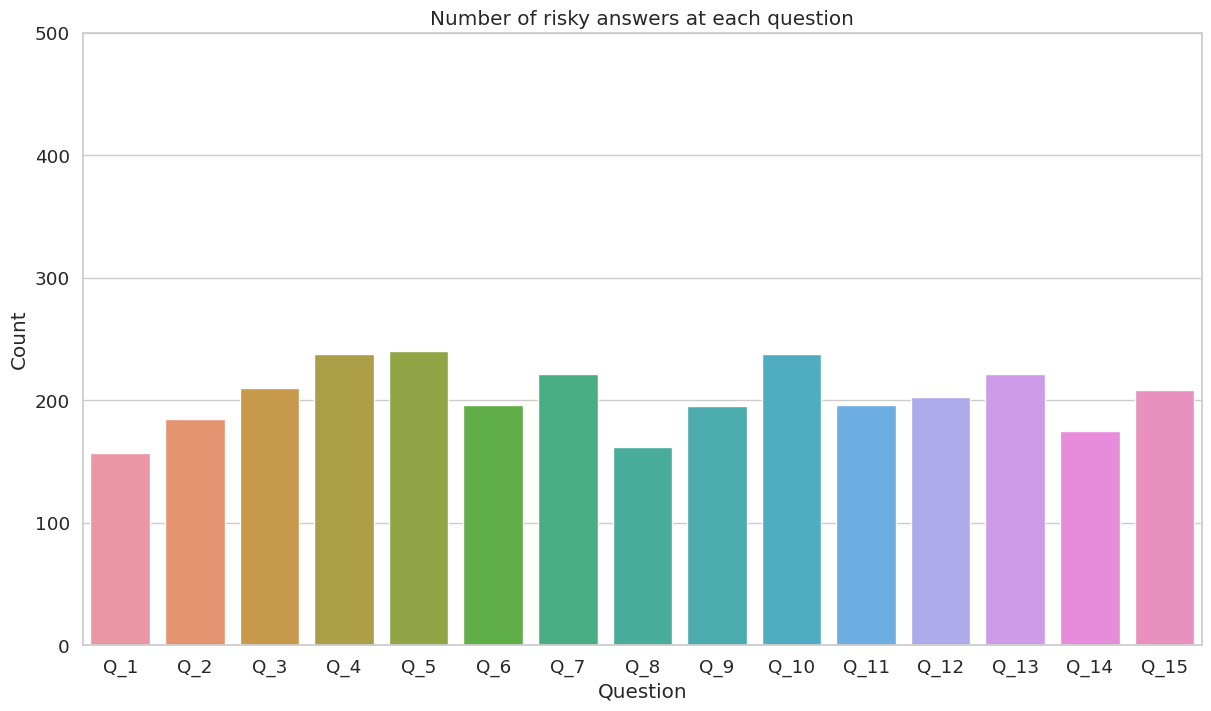

In [172]:
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
plt.figure(figsize=(12,7))

sns.barplot(x=columns_names[:n_questions], y=questions)

plt.ylim(0,len(data_1))
plt.xlabel('Question')
plt.ylabel('Count')
plt.title('Number of risky answers at each question')
plt.show()

In [173]:
data_sum = data_1.sum(axis=1)

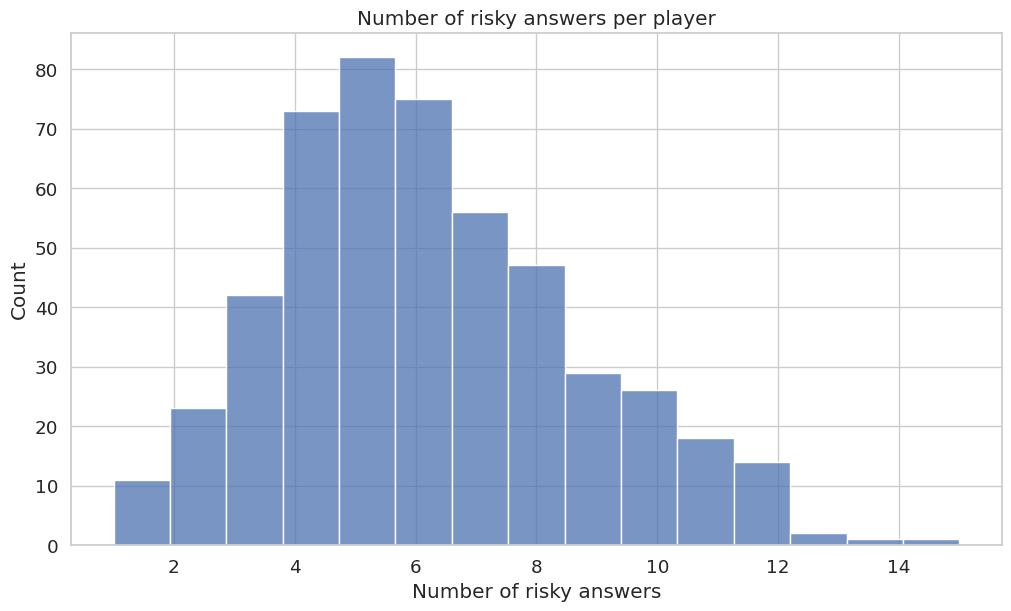

In [174]:
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))

sns.histplot(data_sum, bins=n_questions)

plt.xlabel('Number of risky answers')
plt.ylabel('Count')
plt.title('Number of risky answers per player')
plt.show()

## Inference: Bayesian ITR Models

In [175]:
import os
import arviz as az
import pymc as pm
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.1.4


In [272]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-whitegrid")

In [177]:
n_obs = n_players * n_questions

players = np.array(range(n_players))
questions = np.array(range(n_questions))

# Create array jj
players_obs = []
for i in range(n_players):
  players_obs.extend([i]*n_questions)

# Create array kk
questions_obs = list(range(n_questions))
questions_obs = questions_obs*n_players

# Create array y
answers_obs = list(data_1.values.flatten())

data_bayes = {'J':n_players, 
             'K':n_questions, 
             'N':n_obs, 
             'jj':players_obs, 
             'kk':questions_obs,  
             'y':answers_obs}

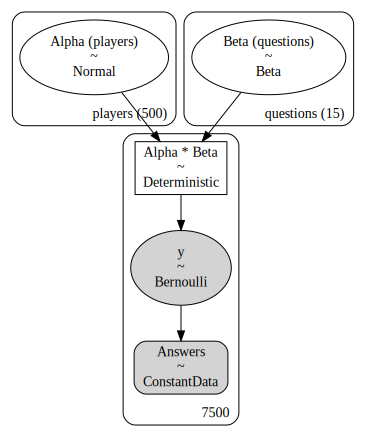

In [178]:
coords = {'players': players, 'questions': questions}

with pm.Model(coords=coords) as model:

    # Data
    answers = pm.Data("Answers", answers_obs, mutable=False)

    # Priors
    alpha = pm.Normal("Alpha (players)", -1, 1.5, dims="players")
    beta = pm.Beta("Beta (questions)", 1, 1, dims="questions")

    # Deterministic
    eta = pm.Deterministic("Alpha * Beta", alpha[players_obs] * beta[questions_obs])

    # Likelihood
    y = pm.Bernoulli("y", logit_p=eta, observed=answers)

pm.model_to_graphviz(model)

In [179]:
with model:
    trace = pm.sample(1000, tune=1500, chains=4, random_seed=RANDOM_SEED)

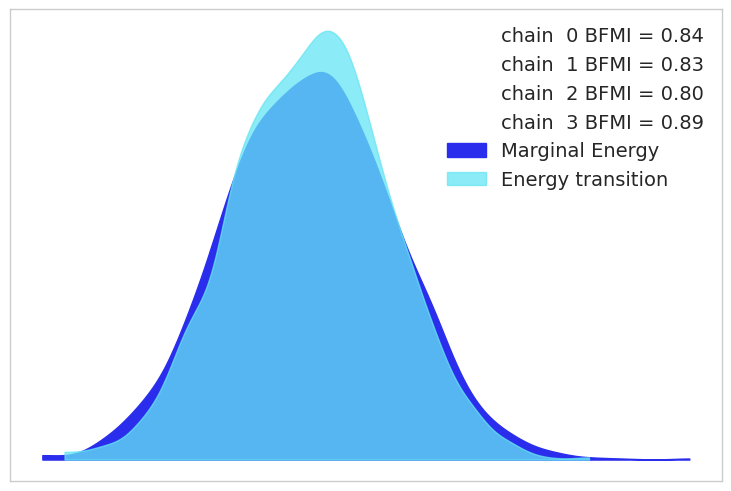

In [273]:
az.plot_energy(trace)

In [181]:
CI = 0.94
func_dict = {
            f'hdi_low_{CI}': lambda x: az.hdi(x, hdi_prob=CI)[0],
            f'hdi_high_{CI}': lambda x: az.hdi(x, hdi_prob=CI)[1]
            }
summary_posteriors = az.summary(trace, stat_funcs=func_dict, extend=True)
summary_posteriors

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,hdi_low_0.94,hdi_high_0.94
Alpha (players)[0],0.670,0.917,-1.049,2.366,0.010,0.013,9303.0,2503.0,1.0,-1.049,2.366
Alpha (players)[1],-2.776,1.068,-4.783,-0.722,0.012,0.010,7837.0,2525.0,1.0,-4.783,-0.722
Alpha (players)[2],-1.528,0.963,-3.268,0.331,0.010,0.011,8742.0,2743.0,1.0,-3.268,0.331
Alpha (players)[3],-0.386,0.870,-1.916,1.286,0.010,0.014,8375.0,2519.0,1.0,-1.916,1.286
Alpha (players)[4],-2.210,1.031,-4.195,-0.345,0.010,0.010,9964.0,2870.0,1.0,-4.195,-0.345
...,...,...,...,...,...,...,...,...,...,...,...
Alpha * Beta[7495],0.313,0.472,-0.636,1.139,0.005,0.007,7675.0,2726.0,1.0,-0.636,1.139
Alpha * Beta[7496],0.285,0.431,-0.515,1.094,0.005,0.006,6621.0,2688.0,1.0,-0.515,1.094
Alpha * Beta[7497],0.172,0.264,-0.303,0.705,0.003,0.004,6724.0,2535.0,1.0,-0.303,0.705
Alpha * Beta[7498],0.438,0.667,-0.843,1.663,0.008,0.010,6986.0,2391.0,1.0,-0.843,1.663


In [182]:
'''
# Checking that summary combines all chains... (Spoiler: yes)
player_0 = []
for i in range(4):
  trials = list(trace.posterior['Alpha (players)'][i, :, 0].to_numpy())
  player_0.extend(trials)
sum(player_0)/len(player_0)
'''

"\n# Checking that summary combines all chains... (Spoiler: yes)\nplayer_0 = []\nfor i in range(4):\n  trials = list(trace.posterior['Alpha (players)'][i, :, 0].to_numpy())\n  player_0.extend(trials)\nsum(player_0)/len(player_0)\n"

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f39e7924790>,
      dtype=object)

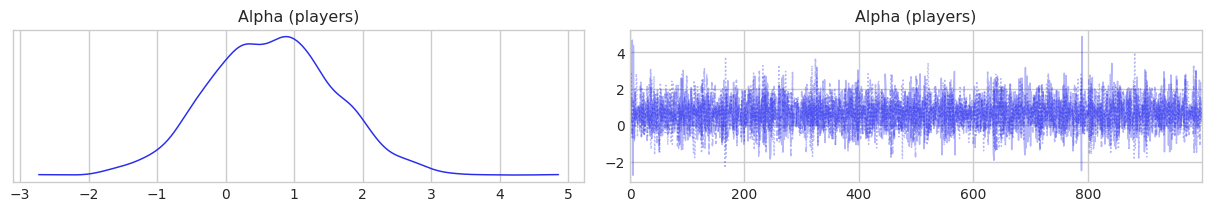

In [274]:
az.plot_trace(trace.posterior['Alpha (players)'][:, :, 0], combined=True)

Text(0.5, 1.0, 'Posteriors of Beta parameters (questions)')

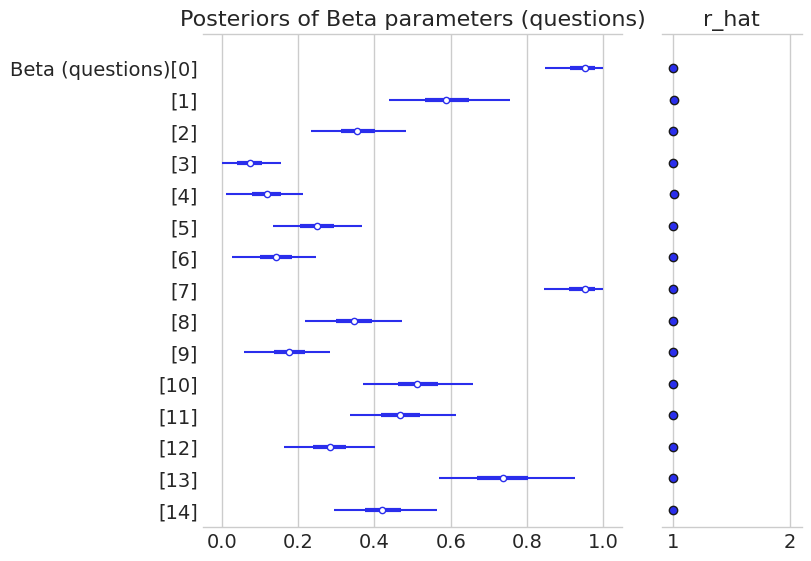

In [275]:
axes = az.plot_forest(trace, var_names=["Beta (questions)"], combined=True, r_hat=True)
axes[0].set_title('Posteriors of Beta parameters (questions)')

Text(0.5, 1.0, 'Posteriors of Beta parameters (questions)')

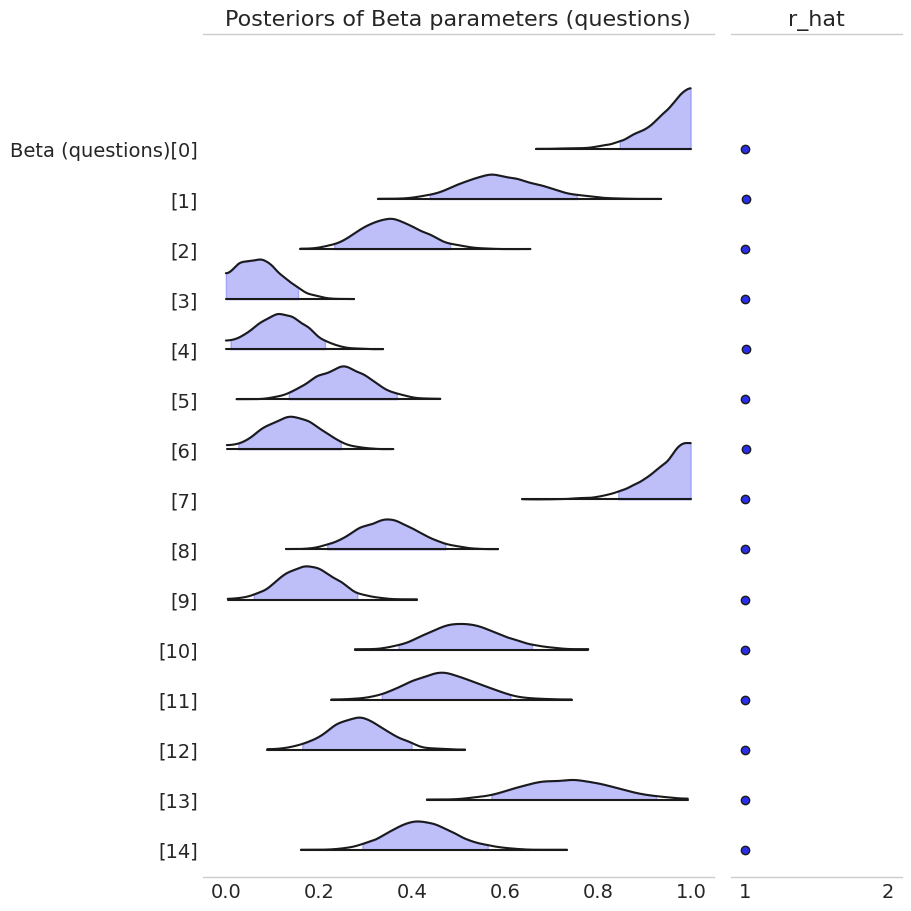

In [290]:
axes = az.plot_forest(trace, var_names=["Beta (questions)"], kind='ridgeplot', combined=True, r_hat=True, ridgeplot_overlap=1, ridgeplot_alpha=0.3, ridgeplot_truncate=False, figsize=(9, 9))
axes[0].set_title('Posteriors of Beta parameters (questions)')
# axes[0].grid(True)
# axes[1].grid(True)

/usr/local/lib/python3.7/dist-packages/IPython/core/events.py:88: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


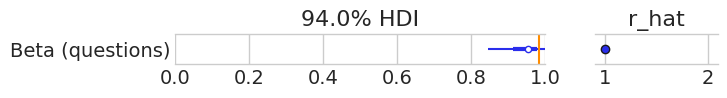

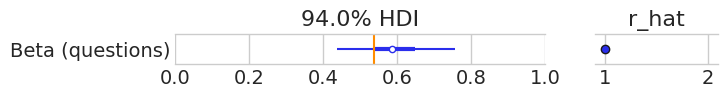

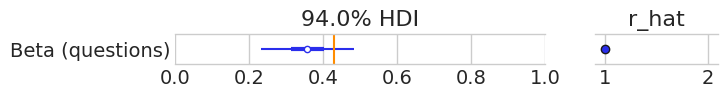

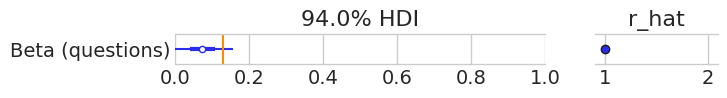

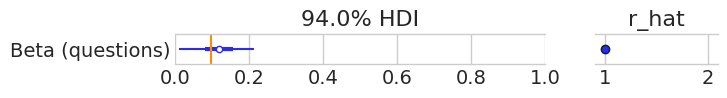

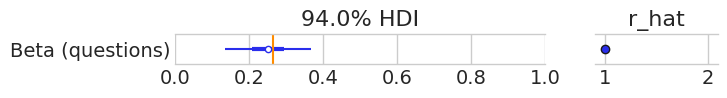

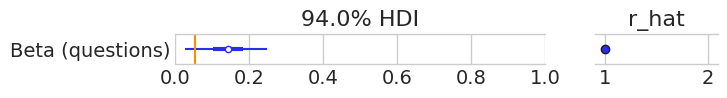

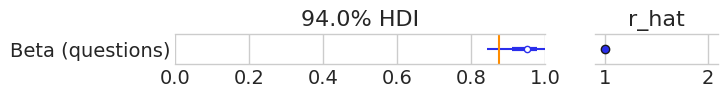

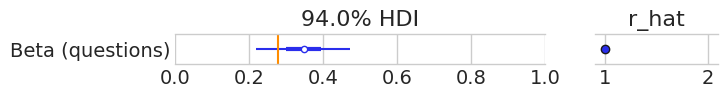

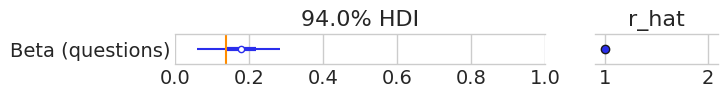

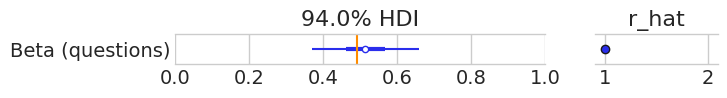

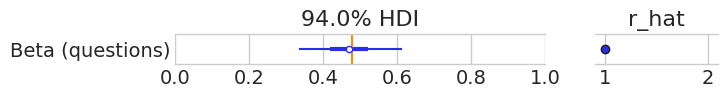

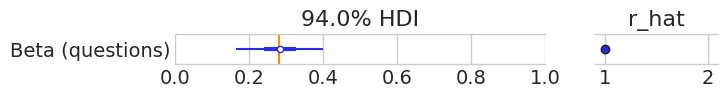

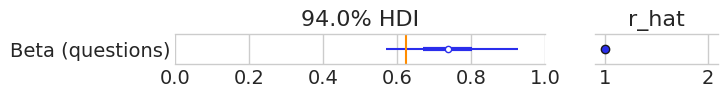

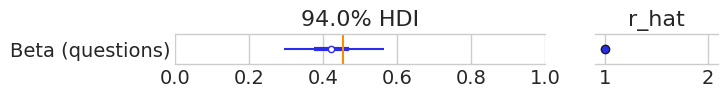

In [277]:
for q in range(n_questions):
  aaa = az.plot_forest(trace.posterior["Beta (questions)"][:,:,q], combined=True, r_hat=True, figsize=(7,0.4))
  aaa[0].vlines(x=game_1.difficulty_questions[q], ymin=-0.4, ymax=0.4, colors=['darkorange'])
  aaa[0].set_xlim([0, 1])
  aaa[0].set_ylim([-0.4, 0.4])

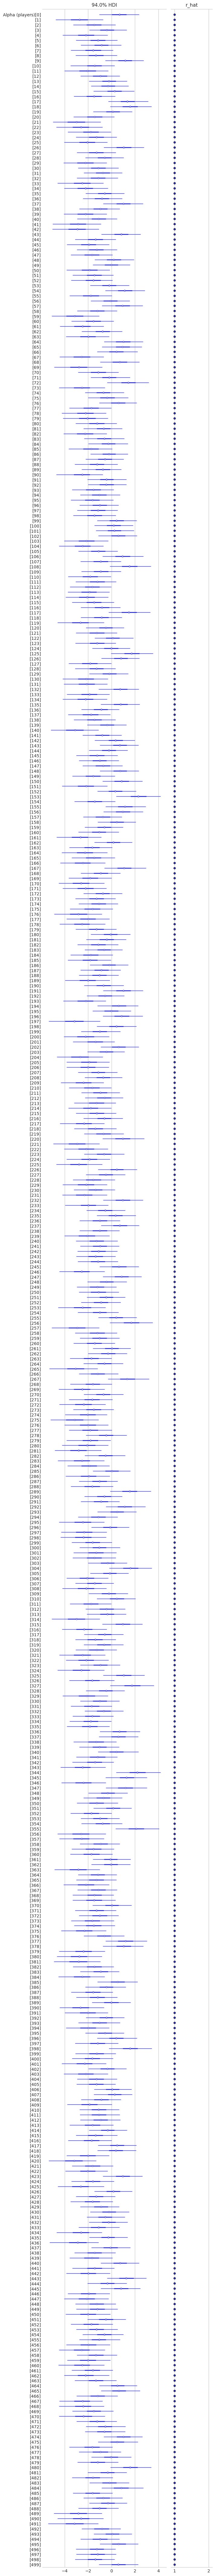

In [278]:
az.plot_forest(trace, var_names=["Alpha (players)"], combined=True, r_hat=True, textsize=10, figsize=(7,85));

### Results

In [186]:
means_players_pred = summary_posteriors['mean'][:n_players]

y_true = Dataset.loc[:,'alpha_risk']
y_true_profile = Dataset.loc[:,'risk_label']

In [209]:
print('PREDICTION PLAYERS:\n')

from collections import Counter

bingos = []
for i in range(n_players):
  hdi_low = summary_posteriors.iloc[i][f'hdi_low_{CI}']
  hdi_high = summary_posteriors.iloc[i][f'hdi_high_{CI}']
  assert hdi_low < hdi_high
  if hdi_low <= y_true[i] <= hdi_high:
    bingos.append('CORRECT')
  else:
    bingos.append('ERROR')
count_bingos = Counter(bingos)
print(count_bingos)
acc = count_bingos['CORRECT']/len(bingos)
print(f'Accuracy = {acc:.3f}')

PREDICTION PLAYERS:

Counter({'CORRECT': 470, 'ERROR': 30})
Accuracy = 0.940


In [210]:
print('PREDICTION QUESTIONS:\n')

from collections import Counter

bingos_q = []
for i in range(n_questions):
  hdi_low = summary_posteriors.loc[f'Beta (questions)[{i}]'][f'hdi_low_{CI}']
  hdi_high = summary_posteriors.loc[f'Beta (questions)[{i}]'][f'hdi_high_{CI}']
  assert hdi_low < hdi_high
  if hdi_low <= game_1.difficulty_questions[i] <= hdi_high:
    bingos_q.append('CORRECT')
  else:
    bingos_q.append('ERROR')
count_bingos_q = Counter(bingos_q)
print(count_bingos_q)
acc = count_bingos_q['CORRECT']/len(bingos_q)
print(f'Accuracy = {acc:.3f}')

PREDICTION QUESTIONS:

Counter({'CORRECT': 15})
Accuracy = 1.000


### Plots



CORRECT


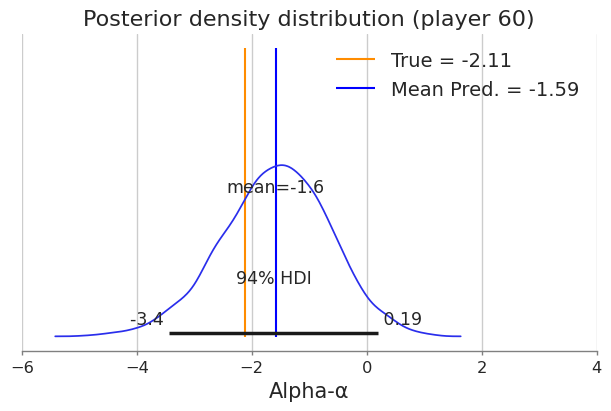

CORRECT


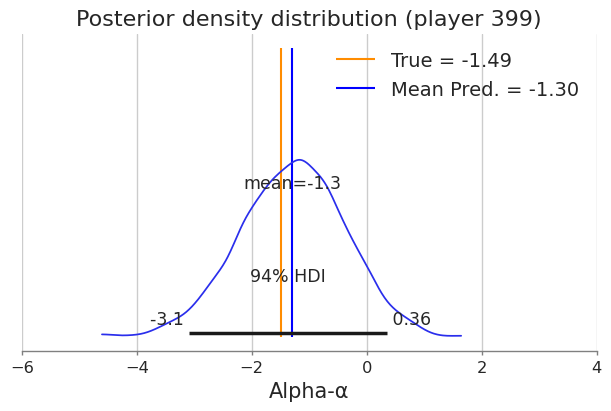

CORRECT


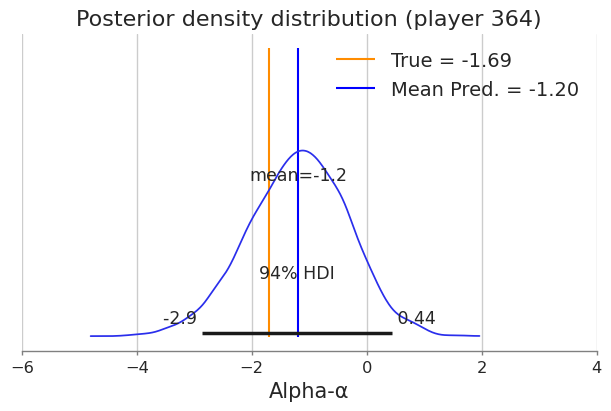

CORRECT


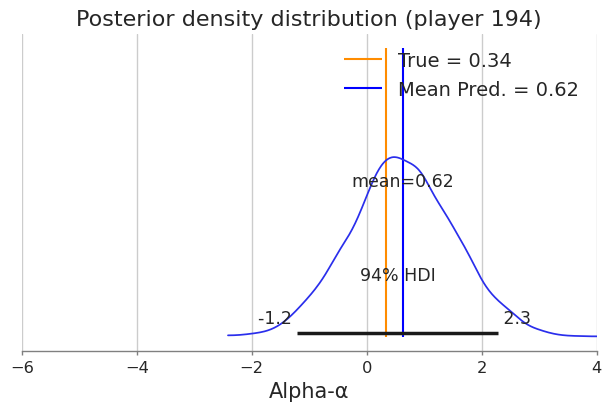

CORRECT


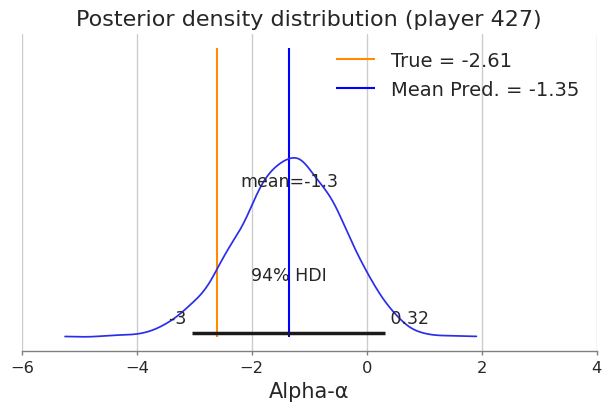

CORRECT


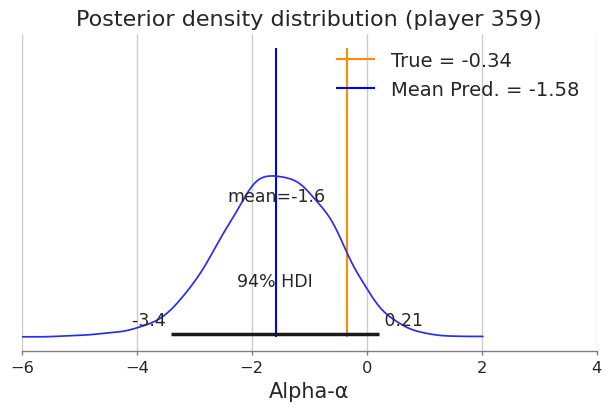

ERROR


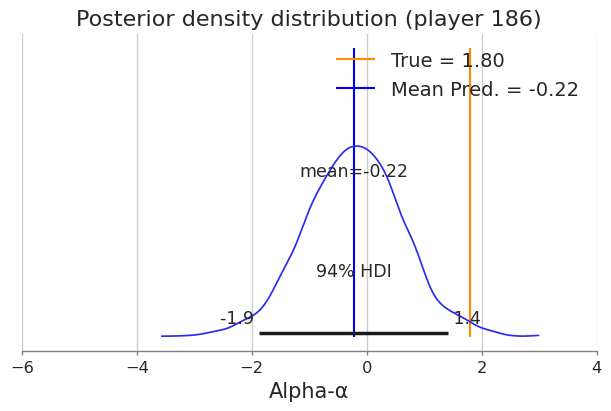

CORRECT


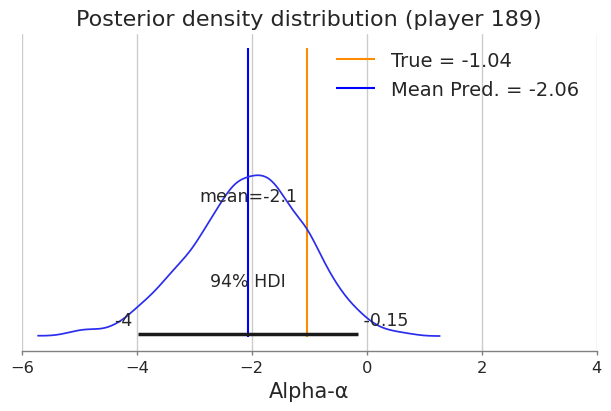

CORRECT


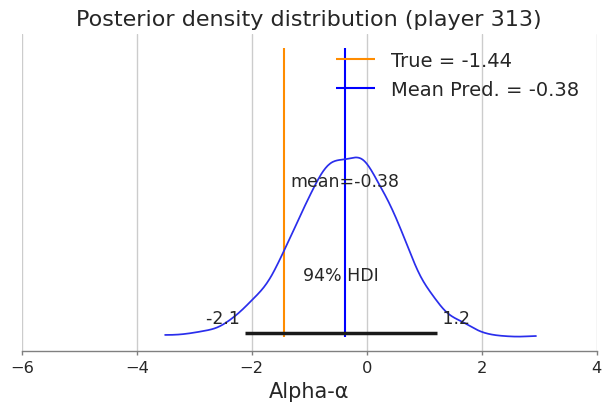

ERROR


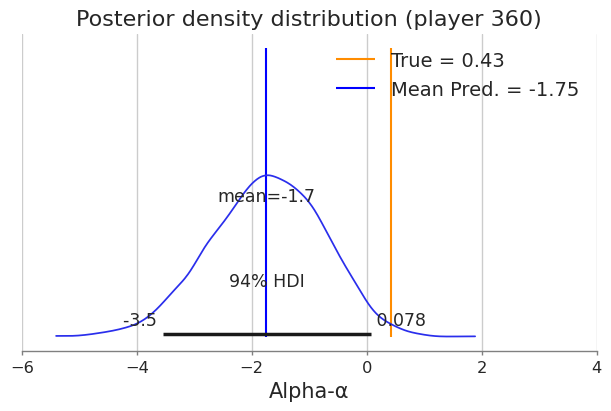

CORRECT


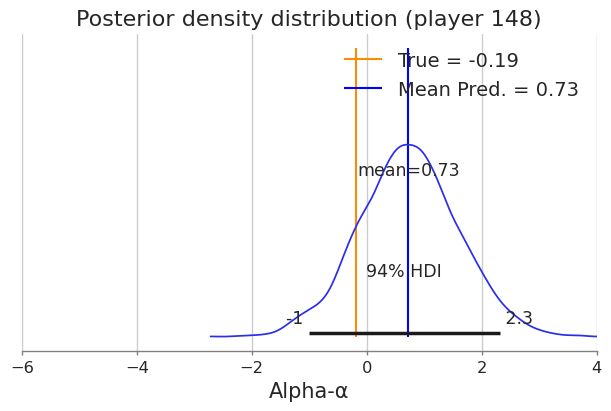

CORRECT


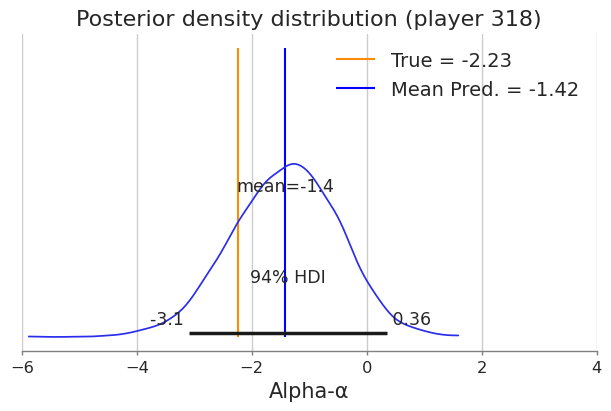

CORRECT


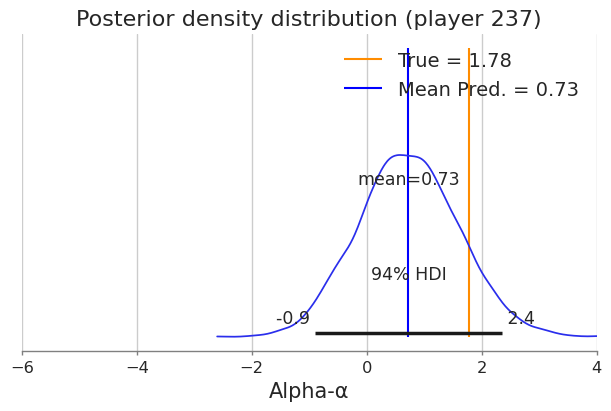

ERROR


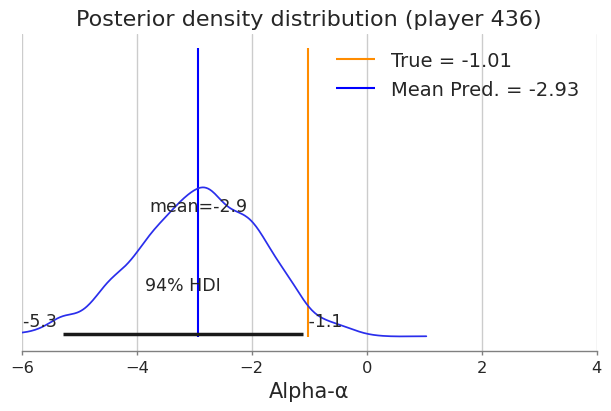

CORRECT


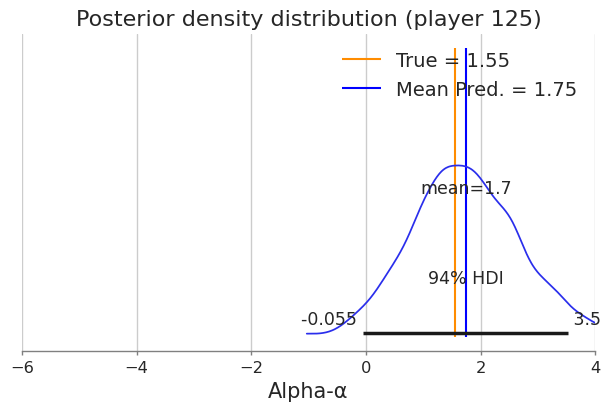

CORRECT


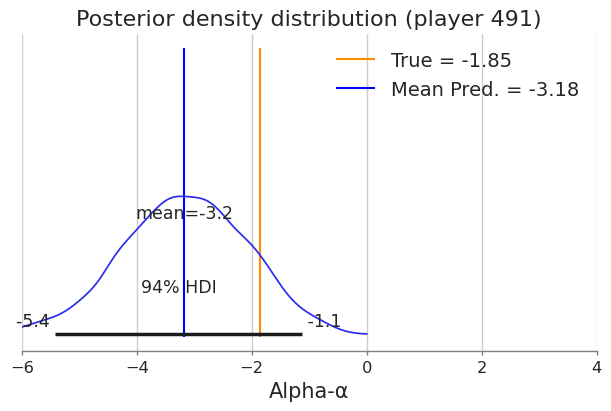

CORRECT


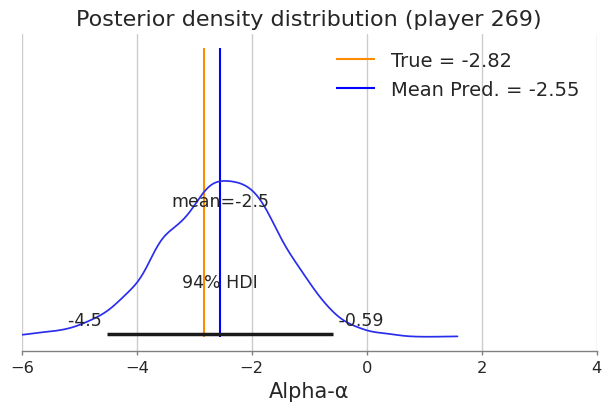

ERROR


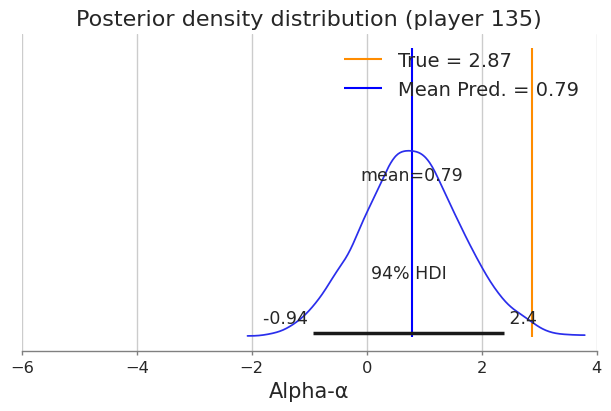

CORRECT


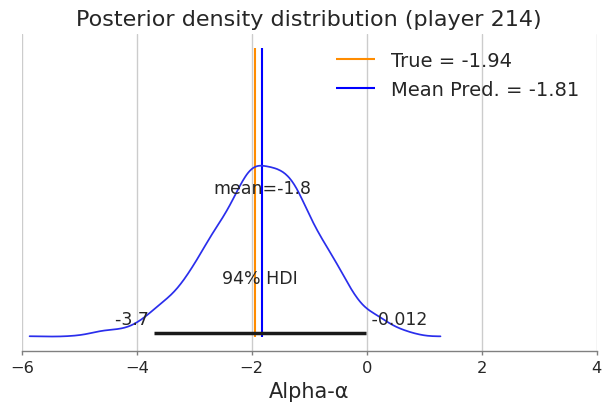

CORRECT


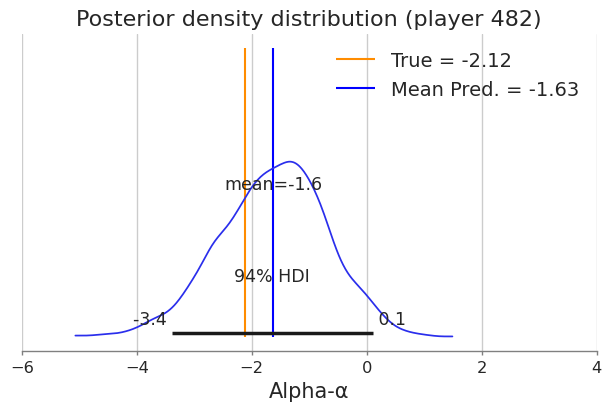

In [289]:
# Plot 20 (randomly selected) players' posteriors 
players_plot = np.random.randint(0, n_players, size=20)

for i in players_plot:
    hdi_low = summary_posteriors.iloc[i][f'hdi_low_{CI}']
    hdi_high = summary_posteriors.iloc[i][f'hdi_high_{CI}']
    if hdi_low <= y_true[i] <= hdi_high:
      print('\033[1m' + '\033[92m' + 'CORRECT' + '\033[92m' + '\033[0m')
    else:
      print('\033[1m' + '\033[91m' + 'ERROR' + '\033[91m' + '\033[0m')
    # print(hdi_low, hdi_high)
    # print(bingos[i])
    player_draws = trace.posterior['Alpha (players)'][:, :, i]
    az.plot_posterior(player_draws, hdi_prob=CI, figsize=(6,4))
    x_line = y_true[i]
    plt.vlines(x=x_line, ymin=0, ymax=0.7, colors=['darkorange'], label=f'True = {x_line:.2f}')
    x_line_pred = summary_posteriors['mean'][i]
    plt.vlines(x=x_line_pred, ymin=0, ymax=0.7, colors=['blue'], label=f'Mean Pred. = {x_line_pred:.2f}')
    plt.legend(loc='best')
    plt.xlabel('Alpha-α')
    plt.xlim([-6, 4])
    plt.title(f'Posterior density distribution (player {i})')
    plt.grid(True)
    plt.show()

CORRECT


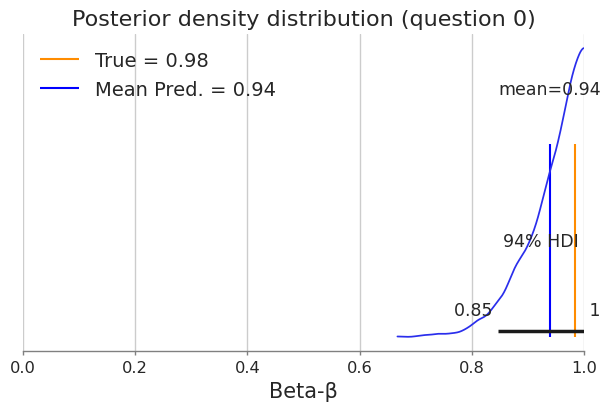

CORRECT


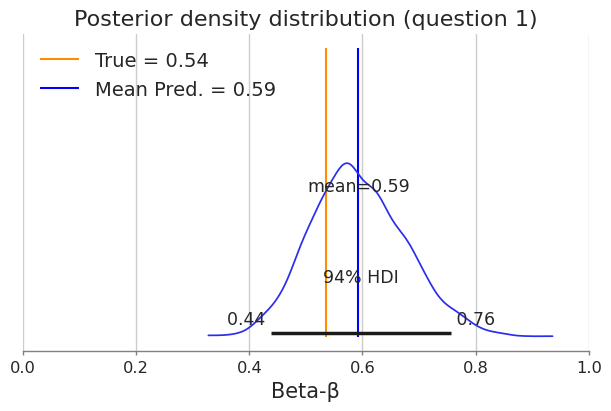

CORRECT


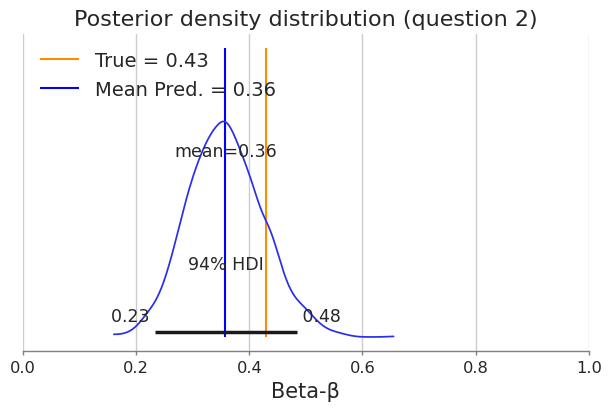

CORRECT


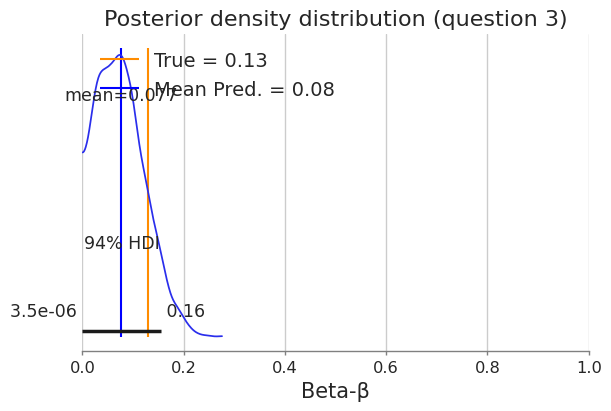

CORRECT


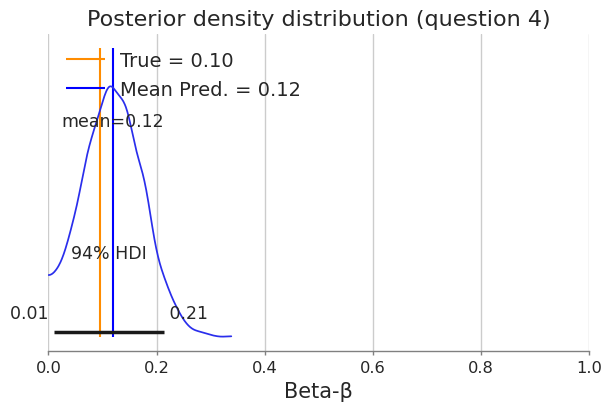

CORRECT


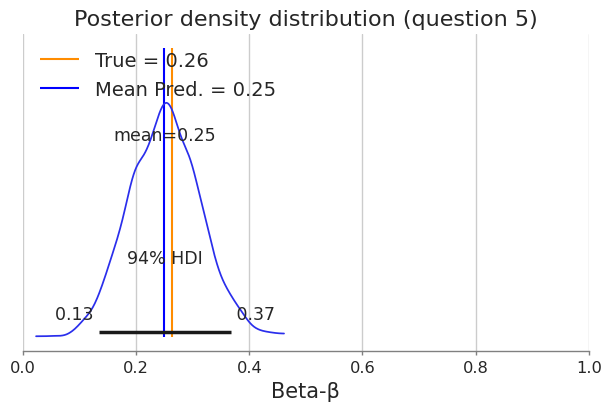

CORRECT


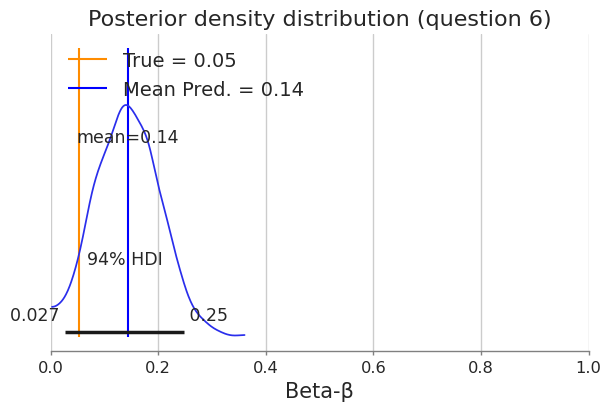

CORRECT


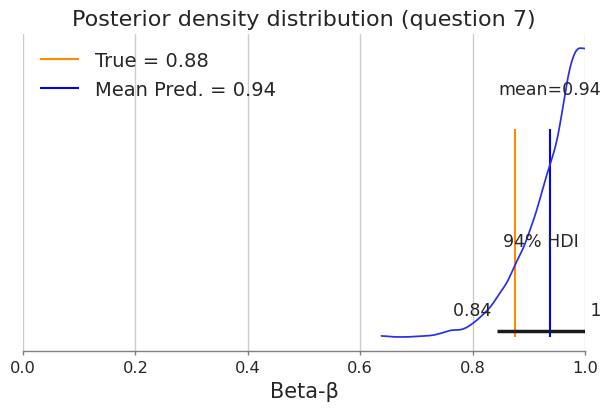

CORRECT


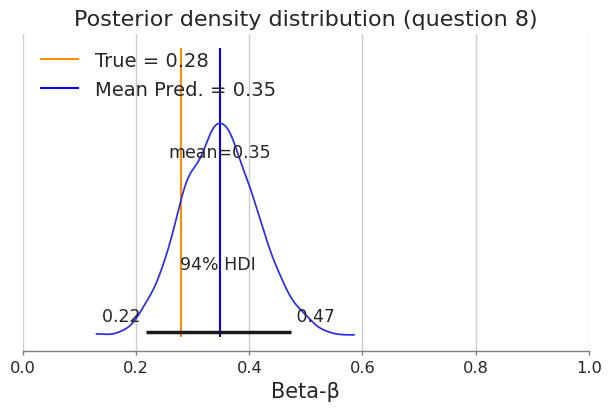

CORRECT


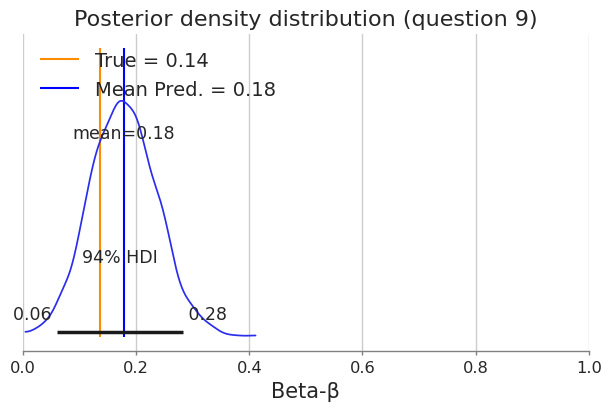

CORRECT


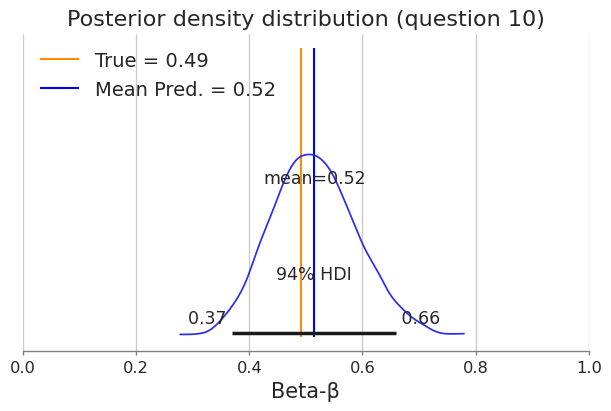

CORRECT


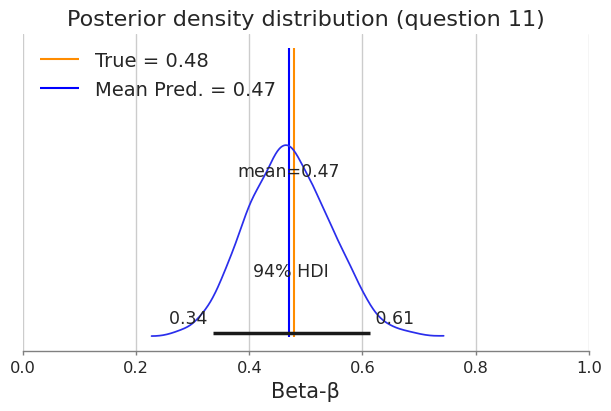

CORRECT


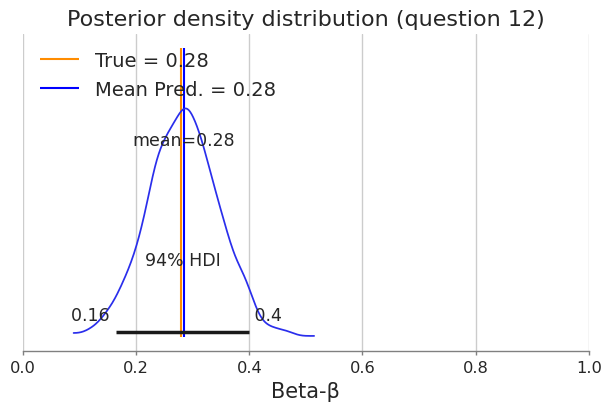

CORRECT


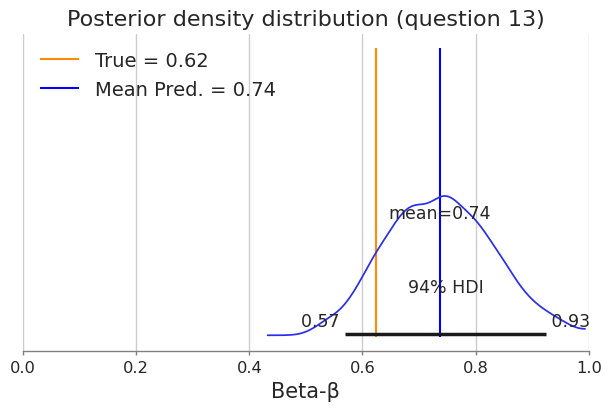

CORRECT


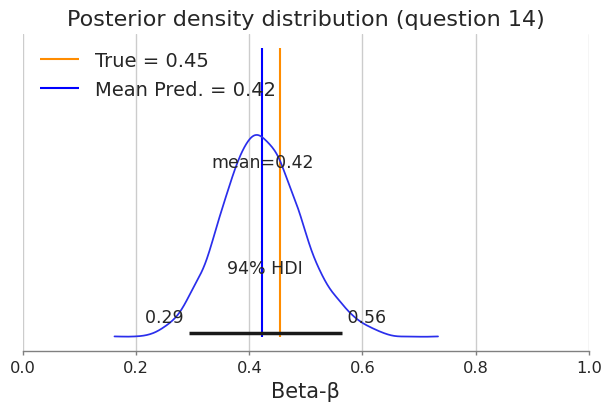

In [280]:
for i in range(n_questions):
    # difficulty
    difficulty = game_1.difficulty_questions[i]

    hdi_low = summary_posteriors.loc[f'Beta (questions)[{i}]'][f'hdi_low_{CI}']
    hdi_high = summary_posteriors.loc[f'Beta (questions)[{i}]'][f'hdi_high_{CI}']
    if hdi_low <= difficulty <= hdi_high:
      print('\033[1m' + '\033[92m' + 'CORRECT' + '\033[92m' + '\033[0m')
    else:
      print('\033[1m' + '\033[91m' + 'ERROR' + '\033[91m' + '\033[0m')

    questions_draws = trace.posterior['Beta (questions)'][:, :, i]
    
    az.plot_posterior(questions_draws, hdi_prob=CI, figsize=(6,4))
    x_line = difficulty
    plt.vlines(x=x_line, ymin=0, ymax=8, colors=['darkorange'], label=f'True = {x_line:.2f}')
    x_line_pred = summary_posteriors.loc[f'Beta (questions)[{i}]']['mean']
    plt.vlines(x=x_line_pred, ymin=0, ymax=8, colors=['blue'], label=f'Mean Pred. = {x_line_pred:.2f}')
    plt.legend(loc='upper left')
    plt.xlim([0, 1])
    plt.xlabel('Beta-β')
    plt.title(f'Posterior density distribution (question {i})')
    plt.grid(True)
    plt.show()